In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pylab as plt
from camcar_new import *
import time


car = CamCar()

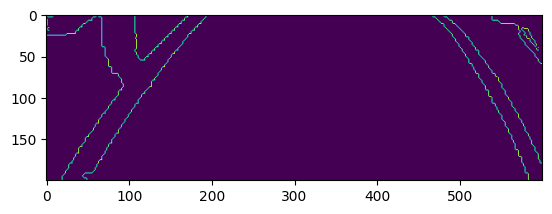

In [2]:


img = car.get_prep_image()
plt.imshow(img)



In [3]:

line_segments = car.calc_line_segments(img)
print(line_segments)

[[[ 91 133 120  92]]

 [[124  88 135  73]]

 [[175  23 184  12]]

 [[118  55 171   2]]

 [[551 125 567 156]]

 [[ 33 173  71 117]]

 [[489  22 535  92]]

 [[ 19 195  39 165]]

 [[165  33 179  17]]

 [[573  27 584  41]]

 [[ 67  38  67   4]]

 [[529  54 535  62]]

 [[109  30 109  41]]

 [[155  47 175  22]]

 [[531  58 551  84]]

 [[143  29 169   3]]

 [[510  27 527  52]]

 [[517  66 535  94]]

 [[ 71 119  81 103]]

 [[ 71 165 103 117]]

 [[587 155 595 171]]

 [[550  11 566  11]]

 [[  0  25  23  25]]

 [[566 113 579 137]]

 [[563 149 583 196]]

 [[ 61 181  73 163]]

 [[ 78  63  80  71]]

 [[543 108 548 119]]

 [[484   3 506  23]]

 [[ 32  23  58   3]]

 [[507  24 524  49]]

 [[107  22 107   2]]

 [[542  71 548  81]]

 [[147  55 157  43]]

 [[579 139 591 161]]

 [[ 86  71  93  84]]

 [[584  29 594  43]]

 [[135  71 147  57]]

 [[183  15 193   3]]

 [[571  23 571  14]]

 [[ 82 103  93  87]]

 [[551  86 560 103]]

 [[575 128 579 136]]

 [[ 71  40  72  51]]

 [[583  19 595  40]]

 [[586  43

In [4]:
lane_lines = car.average_slope_intercept(img, line_segments)
print('average_slope_intercept:')
print(lane_lines)

Vertikale Linie überspringen, da Steigung unendlich.
Vertikale Linie überspringen, da Steigung unendlich.
Vertikale Linie überspringen, da Steigung unendlich.
Vertikale Linie überspringen, da Steigung unendlich.
Vertikale Linie überspringen, da Steigung unendlich.
left avg:  [ -1.19775229 204.50149666]
right avg:  [   1.5961818 -810.5590528]
average_slope_intercept:
[[[3, 200, 128, 50]], [[633, 200, 539, 50]]]


In [5]:
print(img.shape)

(200, 600)


In [6]:

fahrlinie = car.calc_fahrlinie(img, lane_lines)
#print((fahrlinie[0], fahrlinie[1]), (fahrlinie[2], fahrlinie[3]))

[[[3, 200, 128, 50]], [[633, 200, 539, 50]]]
[[300, 200, 333, 50]]


x1: 3, y1: 200, x2: 128, y2: 50
x1: 633, y1: 200, x2: 539, y2: 50


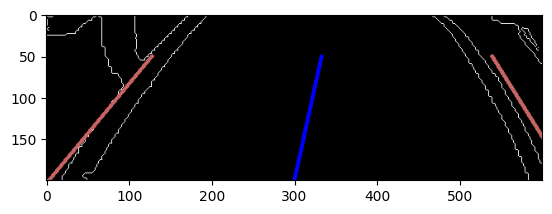

In [7]:
imageresult = car.draw_line_segments(lane_lines, fahrlinie, img)
plt.imshow(imageresult)

In [8]:
lenkwinkel = car.compute_steering_angle(img, lane_lines)


new steering angle: 108
Lenkwinkel: 


In [ ]:
# Video-Schleife
while True:
    img = car.get_prep_image()
    line_segments = car.calc_line_segments(img)
    print(line_segments)
    
    
    if line_segments is not None:
        imageresult = car.draw_line_segments(line_segments, img)
        cv.imshow("Display window (press q to quit)", imageresult)
        # Ende bei Drücken der Taste q
        if cv.waitKey(1) == ord('q'):
            break
        time.sleep(0.3)
    else:
        print('Stop - Keine Linien mehr erkannt.')
        break
   
car.close()
cv.destroyAllWindows()